# Chapter 6

In [1]:
import aesara as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pyreadr
import requests
import seaborn as sns

from plotnine import aes, geom_point, geom_segment, ggplot, stat_function
from scipy.stats import beta, binom, gamma, poisson

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
%load_ext nb_black
RANDOM_SEED = 1301
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

<IPython.core.display.Javascript object>

In [3]:
pm.__version__

'4.0.0b5'

<IPython.core.display.Javascript object>

In [4]:
at.__version__

'2.5.1'

<IPython.core.display.Javascript object>

## 6.1 Grid approximation

## 6.1.1 A Beta-Binomial example

In [5]:
grid_data = pd.DataFrame(data={"pi_grid": np.linspace(0, 1, 6)})
grid_data

,pi_grid
0,0.0
1,0.2
2,0.4
3,0.6
4,0.8
5,1.0


<IPython.core.display.Javascript object>

In [6]:
grid_data = grid_data.assign(
    prior=beta.pdf(grid_data["pi_grid"], 2, 2),
    likelihood=binom.pmf(9, 10, grid_data["pi_grid"]),
)

<IPython.core.display.Javascript object>

In [7]:
grid_data

,pi_grid,prior,likelihood
0,0.0,0.00,0.000000
1,0.2,0.96,0.000004
2,0.4,1.44,0.001573
3,0.6,1.44,0.040311
4,0.8,0.96,0.268435
5,1.0,0.00,0.000000


<IPython.core.display.Javascript object>

In [8]:
grid_data = grid_data.assign(
    unnormalised=grid_data["likelihood"] * grid_data["prior"],
)

<IPython.core.display.Javascript object>

In [9]:
grid_data = grid_data.assign(
    posterior=grid_data["unnormalised"] / grid_data["unnormalised"].sum()
)

<IPython.core.display.Javascript object>

In [10]:
grid_data.sum()

pi_grid         3.000000
prior           4.800000
likelihood      0.310323
unnormalised    0.318014
posterior       1.000000
dtype: float64

<IPython.core.display.Javascript object>

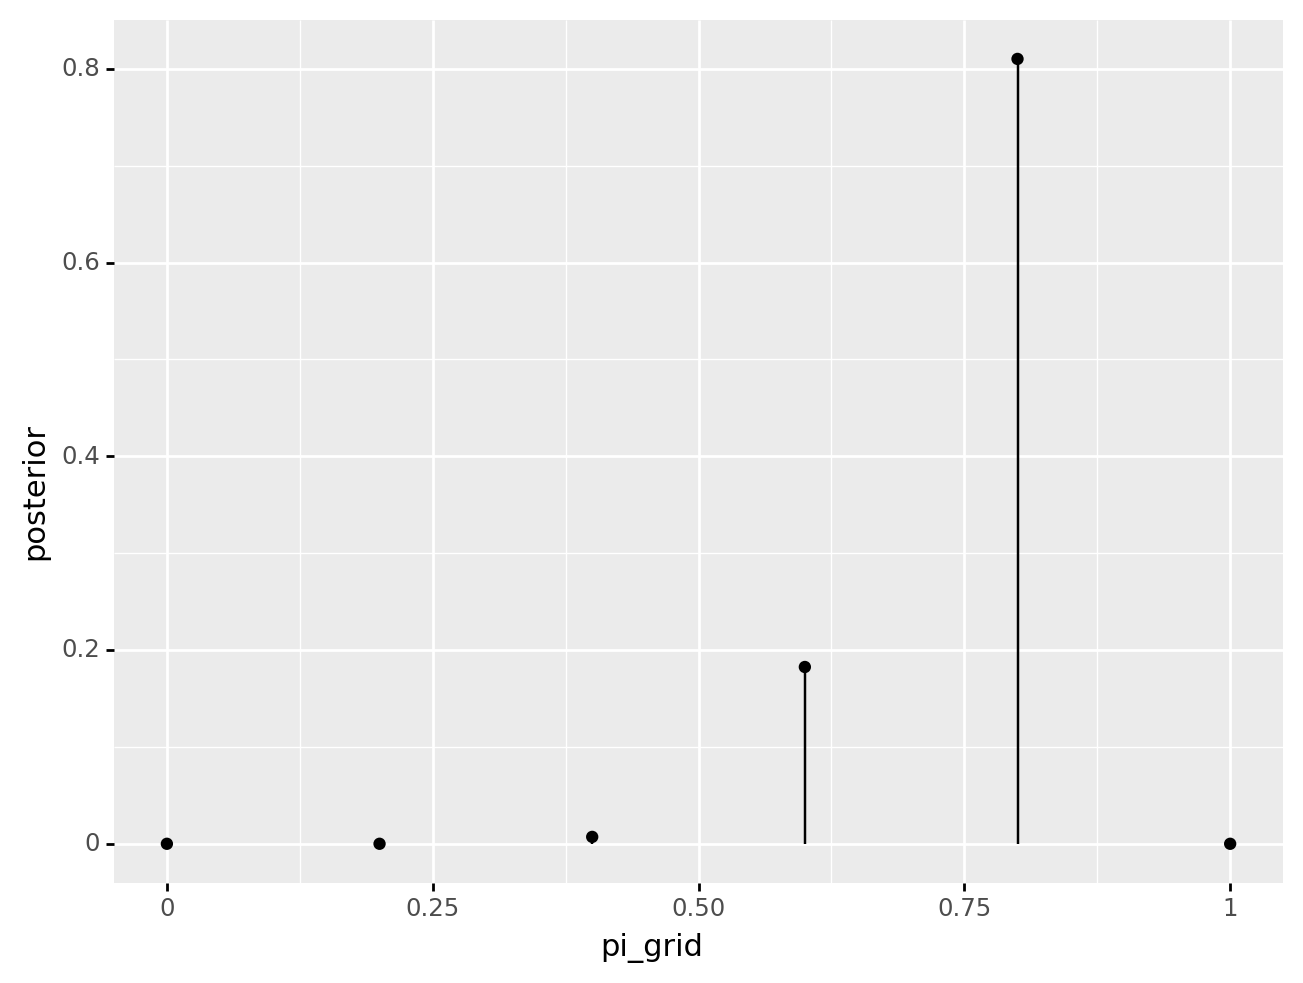

<ggplot: (390118524)>

<IPython.core.display.Javascript object>

In [11]:
(
    ggplot(grid_data, aes(x=grid_data["pi_grid"], y=grid_data["posterior"]))
    + geom_point()
    + geom_segment(
        aes(
            x=grid_data["pi_grid"],
            xend=grid_data["pi_grid"],
            y=0,
            yend=grid_data["posterior"],
        )
    )
)

In [12]:
post_sample = grid_data.sample(10000, weights=grid_data["posterior"], replace=True)

<IPython.core.display.Javascript object>

In [13]:
post_sample

,pi_grid,prior,likelihood,unnormalised,posterior
4,0.8,0.96,0.268435,0.257698,0.810334
4,0.8,0.96,0.268435,0.257698,0.810334
4,0.8,0.96,0.268435,0.257698,0.810334
4,0.8,0.96,0.268435,0.257698,0.810334
4,0.8,0.96,0.268435,0.257698,0.810334
...,...,...,...,...,...
4,0.8,0.96,0.268435,0.257698,0.810334
4,0.8,0.96,0.268435,0.257698,0.810334
4,0.8,0.96,0.268435,0.257698,0.810334
4,0.8,0.96,0.268435,0.257698,0.810334


<IPython.core.display.Javascript object>

In [14]:
pd.concat(
    [
        post_sample["pi_grid"].value_counts().rename("n"),
        post_sample["pi_grid"].value_counts(normalize=True).rename("percent"),
    ],
    axis=1,
)

,n,percent
0.8,8059,0.8059
0.6,1875,0.1875
0.4,66,0.0066


<IPython.core.display.Javascript object>

In [15]:
# ggplot(post_sample, aes(x = grid_data["pi_grid"])) +
#   geom_histogram(aes(y = ..density..), color = "white") +
#   stat_function(fun = dbeta, args = list(11, 3)) +
#   lims(x = c(0, 1))

<IPython.core.display.Javascript object>

In [16]:
grid_data = pd.DataFrame(data={"pi_grid": np.linspace(0, 1, 101)})

grid_data = grid_data.assign(
    prior=beta.pdf(grid_data["pi_grid"], 2, 2),
    likelihood=binom.pmf(9, 10, grid_data["pi_grid"]),
)

grid_data = grid_data.assign(
    unnormalised=grid_data["likelihood"] * grid_data["prior"],
)

grid_data = grid_data.assign(
    posterior=grid_data["unnormalised"] / grid_data["unnormalised"].sum()
)

<IPython.core.display.Javascript object>

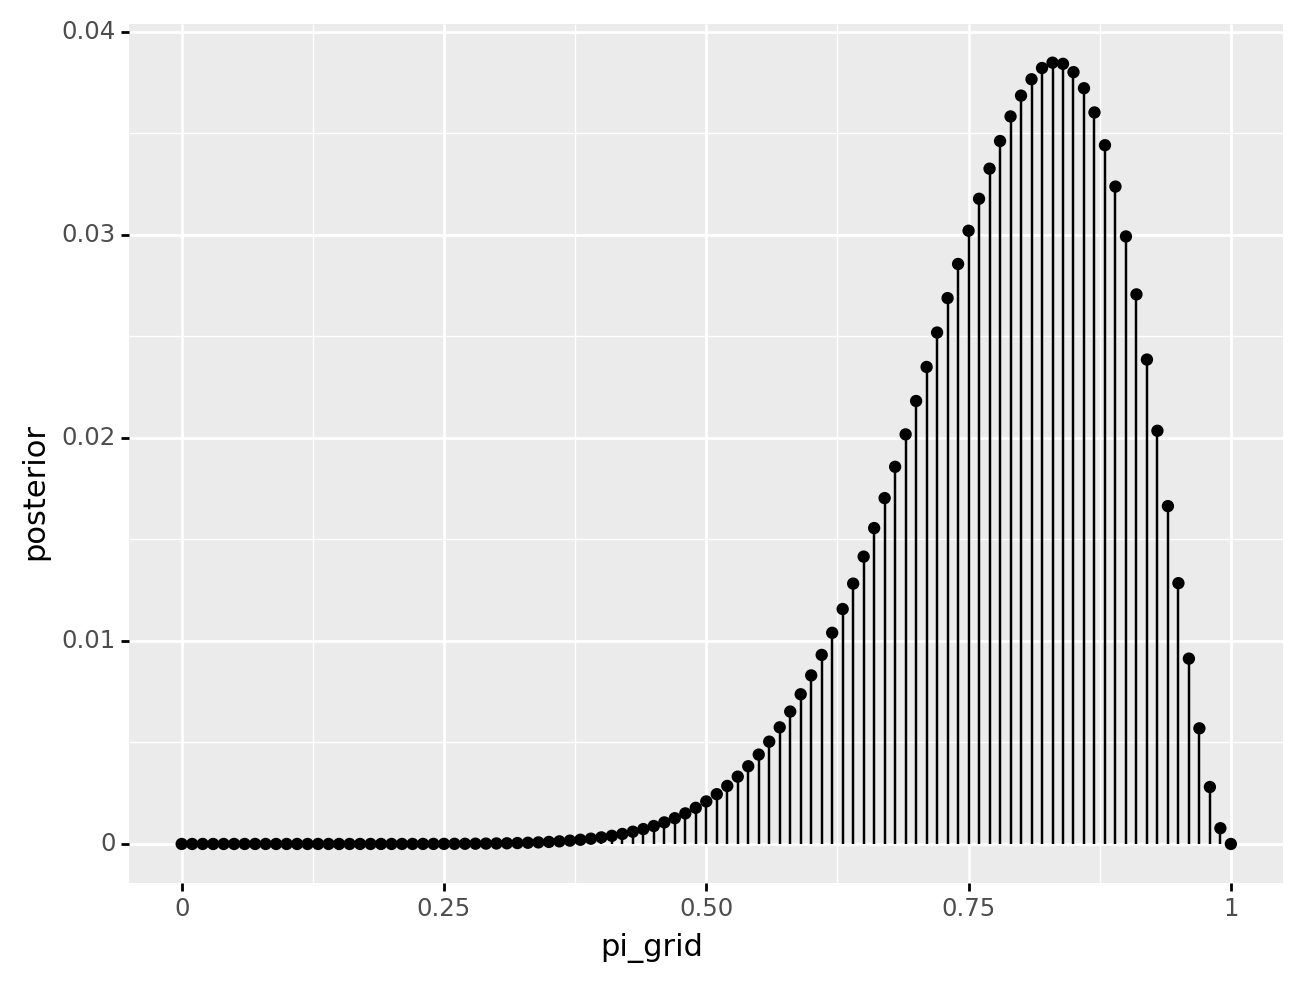

<ggplot: (390669156)>

<IPython.core.display.Javascript object>

In [17]:
(
    ggplot(grid_data, aes(x=grid_data["pi_grid"], y=grid_data["posterior"]))
    + geom_point()
    + geom_segment(
        aes(
            x=grid_data["pi_grid"],
            xend=grid_data["pi_grid"],
            y=0,
            yend=grid_data["posterior"],
        )
    )
)

In [18]:
post_sample = grid_data.sample(10000, weights=grid_data["posterior"], replace=True)

<IPython.core.display.Javascript object>

In [19]:
# ggplot(post_sample,
#        aes(x = pi_grid)) +
# geom_histogram(aes(y = ..density..),
#                åcolor = "white", binwidth = 0.05) + stat_function(fun = dbeta, args = list(11, 3)) + lims(x = c(0, 1))

<IPython.core.display.Javascript object>

## 6.1.2 A Gamma-Poisson example


In [20]:
grid_data = pd.DataFrame(data={"lambda_grid": np.linspace(0, 15, 501)})

grid_data = grid_data.assign(
    prior=gamma.pdf(grid_data["lambda_grid"], 3, 1),
    likelihood=poisson.pmf(2, grid_data["lambda_grid"])
    * poisson.pmf(8, grid_data["lambda_grid"]),
)

grid_data = grid_data.assign(
    unnormalised=grid_data["likelihood"] * grid_data["prior"],
)

grid_data = grid_data.assign(
    posterior=grid_data["unnormalised"] / grid_data["unnormalised"].sum()
)

<IPython.core.display.Javascript object>

In [21]:
post_sample = grid_data.sample(10000, weights=grid_data["posterior"], replace=True)

<IPython.core.display.Javascript object>

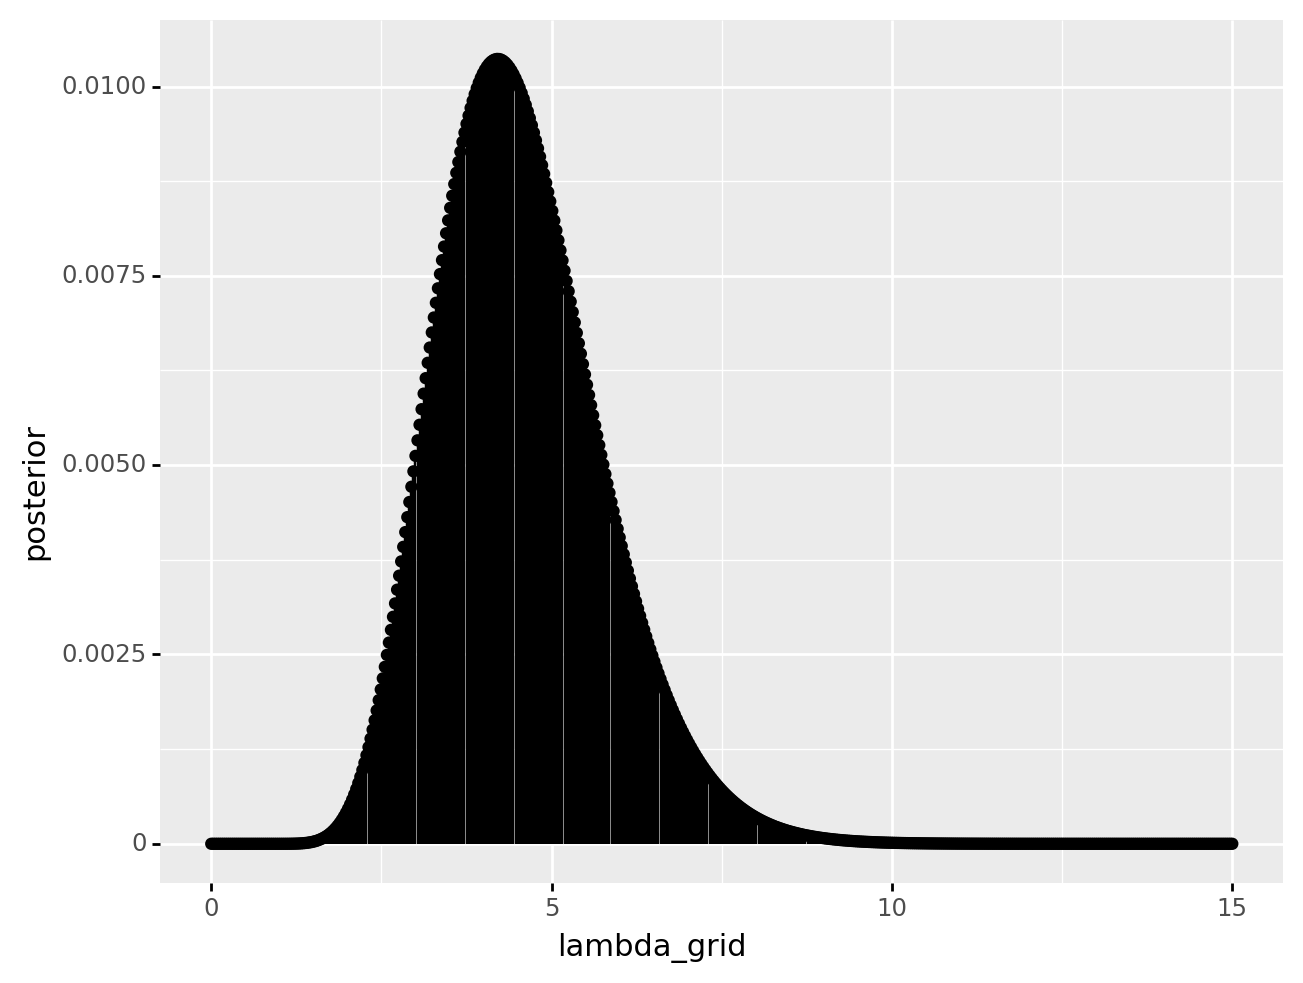

<ggplot: (391415805)>

<IPython.core.display.Javascript object>

In [22]:
(
    ggplot(grid_data, aes(x=grid_data["lambda_grid"], y=grid_data["posterior"]))
    + geom_point()
    + geom_segment(
        aes(
            x=grid_data["lambda_grid"],
            xend=grid_data["lambda_grid"],
            y=0,
            yend=grid_data["posterior"],
        )
    )
)

## 6.2 Markov chains via pymc

### 6.2.1 A Beta-Binomial example

In [23]:
with pm.Model() as beta_binomal_model:
    pi = pm.Beta("beta", 2, 2)
    y = pm.Binomial("y", n=10, p=pi, observed=9)

<IPython.core.display.Javascript object>

In [24]:
with beta_binomal_model:
    trace = pm.sample(5000, tune=5000, chains=4, random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 22 seconds.


<IPython.core.display.Javascript object>

array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

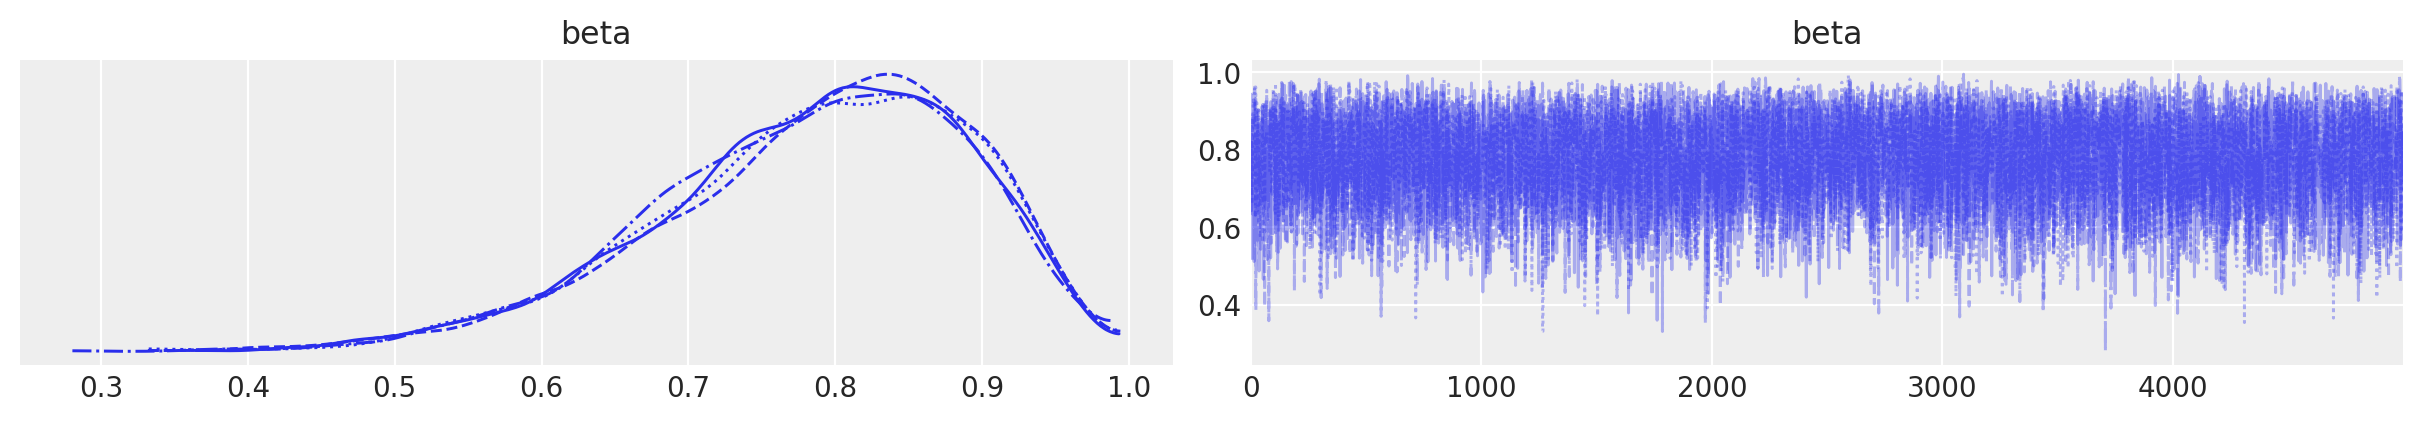

<IPython.core.display.Javascript object>

In [25]:
az.plot_trace(trace)

<AxesSubplot:title={'center':'beta'}>

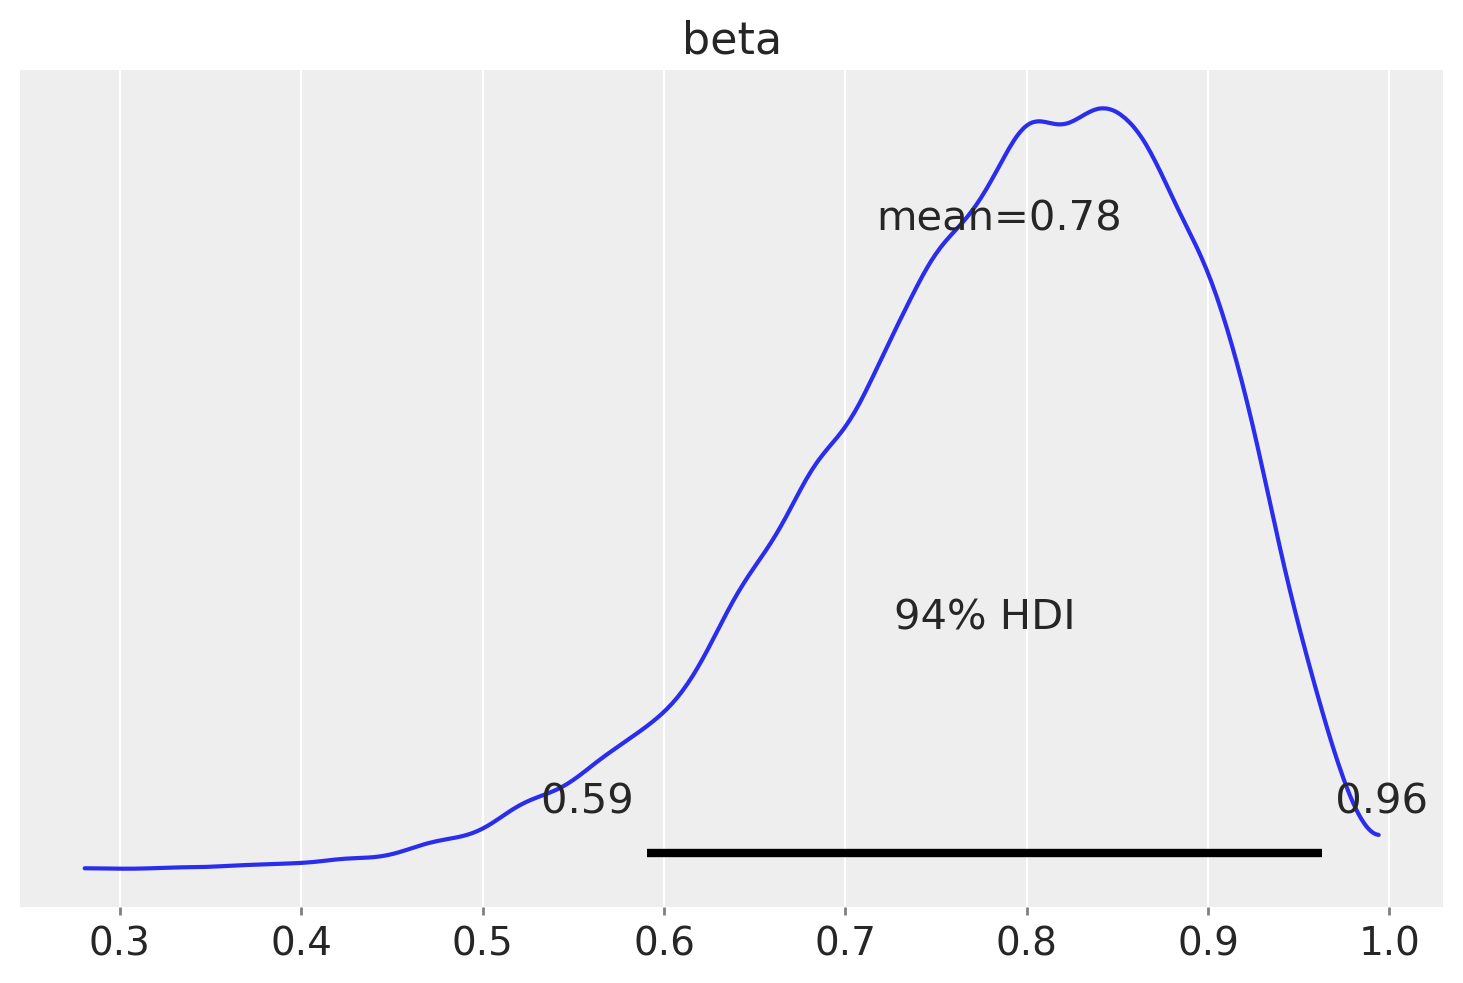

<IPython.core.display.Javascript object>

In [26]:
az.plot_posterior(trace)

### 6.2.2 A Gamma-Poisson example

In [27]:
with pm.Model() as gamma_poisson_model:
    lambda_ = pm.Gamma("lambda", 3, 1)
    y = pm.Poisson("y", mu=lambda_, observed=np.array([2, 8]))
    trace = pm.sample(5000, tune=5000, chains=4, random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.705, but should be close to 0.8. Try to increase the number of tuning steps.


<IPython.core.display.Javascript object>

array([[<AxesSubplot:title={'center':'lambda'}>,
        <AxesSubplot:title={'center':'lambda'}>]], dtype=object)

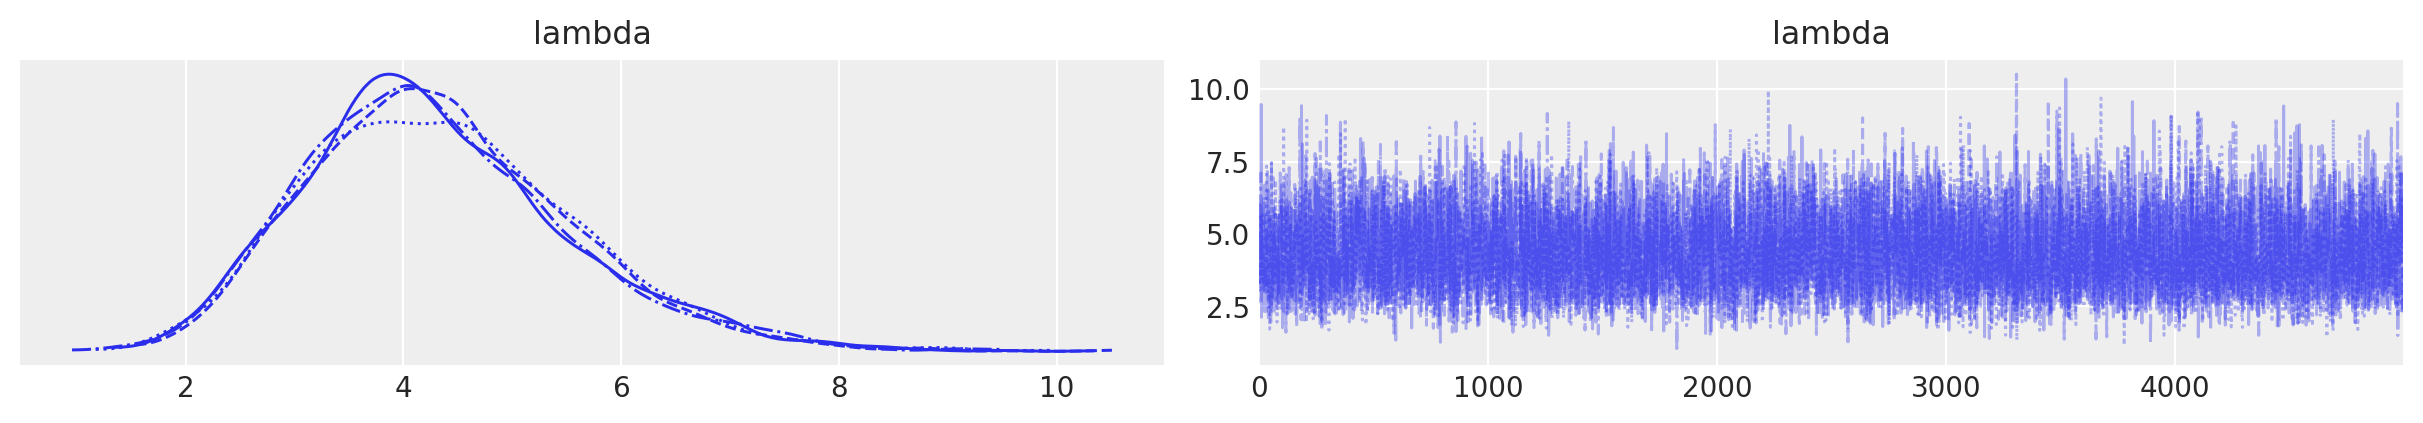

<IPython.core.display.Javascript object>

In [28]:
az.plot_trace(trace)

<AxesSubplot:title={'center':'lambda'}>

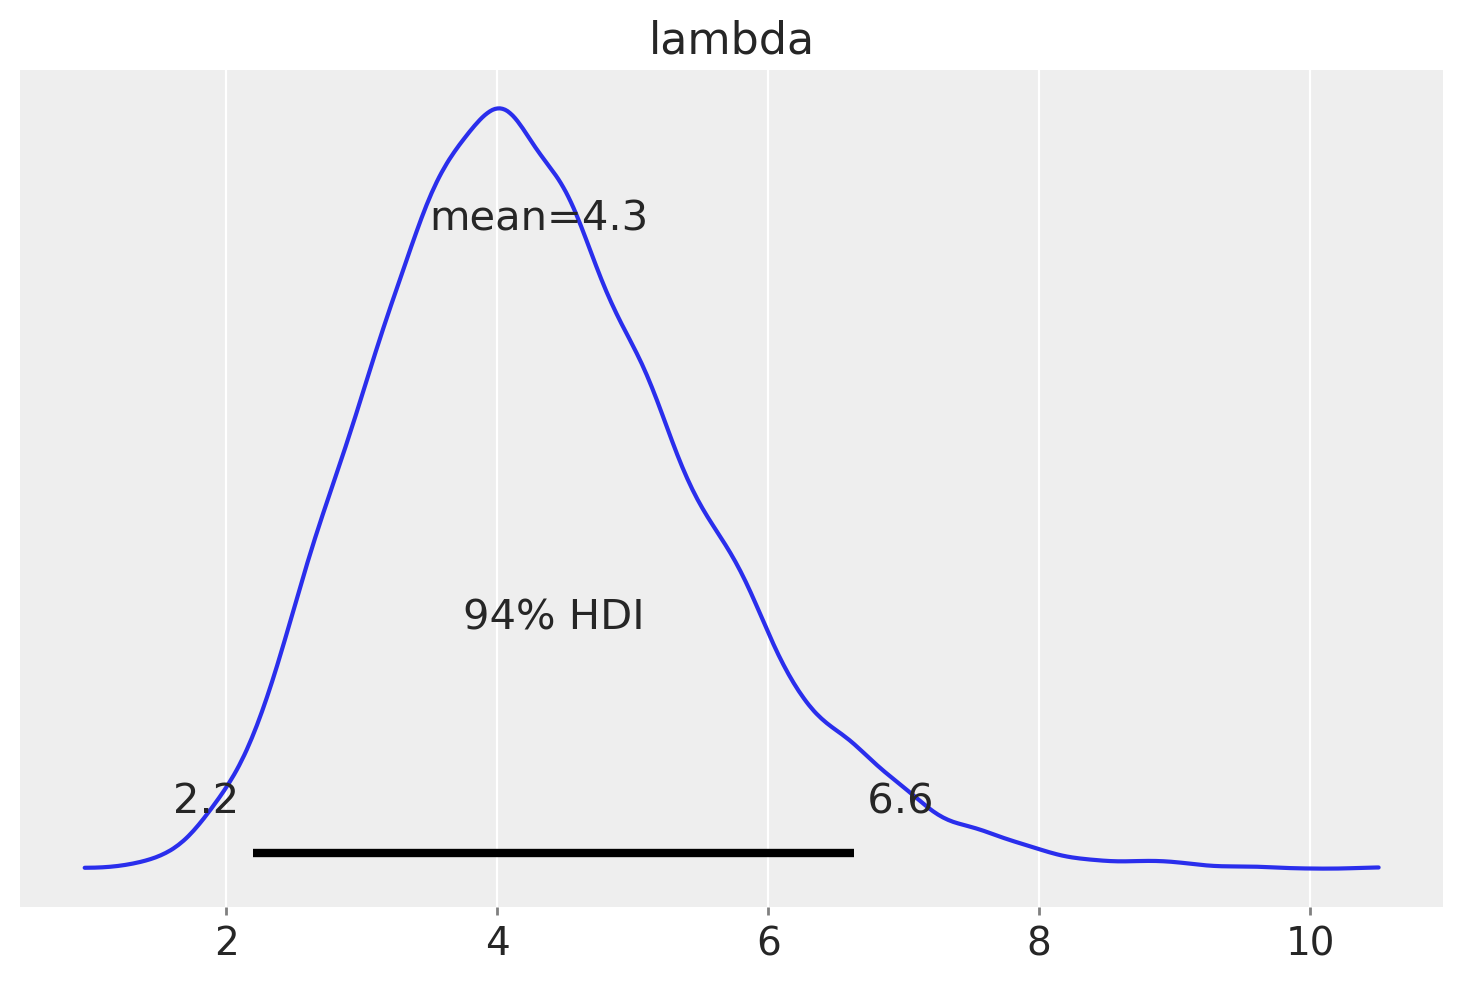

<IPython.core.display.Javascript object>

In [29]:
az.plot_posterior(trace)

## 6.3 Markov chain diagnostics

In [30]:
trace.sample_stats

<xarray.Dataset>
Dimensions:             (chain: 4, draw: 5000)
Coordinates:
  * chain               (chain) int64 0 1 2 3
  * draw                (draw) int64 0 1 2 3 4 5 ... 4995 4996 4997 4998 4999
Data variables: (12/13)
    process_time_diff   (chain, draw) float64 0.000489 0.000404 ... 0.000741
    diverging           (chain, draw) bool False False False ... False False
    energy_error        (chain, draw) float64 0.06471 0.0 ... 0.331 -0.3514
    tree_depth          (chain, draw) int64 1 1 2 1 2 1 1 2 ... 2 2 2 1 2 1 1 2
    step_size_bar       (chain, draw) float64 1.435 1.435 1.435 ... 1.48 1.48
    perf_counter_diff   (chain, draw) float64 0.0004884 0.0004044 ... 0.0007408
    ...                  ...
    perf_counter_start  (chain, draw) float64 1.82e+05 1.82e+05 ... 1.82e+05
    energy              (chain, draw) float64 6.077 8.093 6.452 ... 7.078 6.716
    step_size           (chain, draw) float64 1.279 1.279 1.279 ... 1.525 1.525
    acceptance_rate     (chain, draw) float64 0.9373 0.01962 ... 0.7182 0.9704
    lp                  (chain, draw) float64 -6.073 -6.073 ... -7.054 -6.096
    n_steps             (chain, draw) float64 1.0 1.0 3.0 1.0 ... 1.0 1.0 3.0
Attributes:
    created_at:                 2022-06-24T13:39:20.171501
    arviz_version:              0.12.0
    inference_library:          pymc
    inference_library_version:  4.0.0b5
    sampling_time:              20.200849056243896
    tuning_steps:               5000

<IPython.core.display.Javascript object>

## 6.3.3 Calculating effective sample size & autocorrelation

array([<AxesSubplot:title={'center':'lambda\n0'}>,
       <AxesSubplot:title={'center':'lambda\n1'}>,
       <AxesSubplot:title={'center':'lambda\n2'}>,
       <AxesSubplot:title={'center':'lambda\n3'}>], dtype=object)

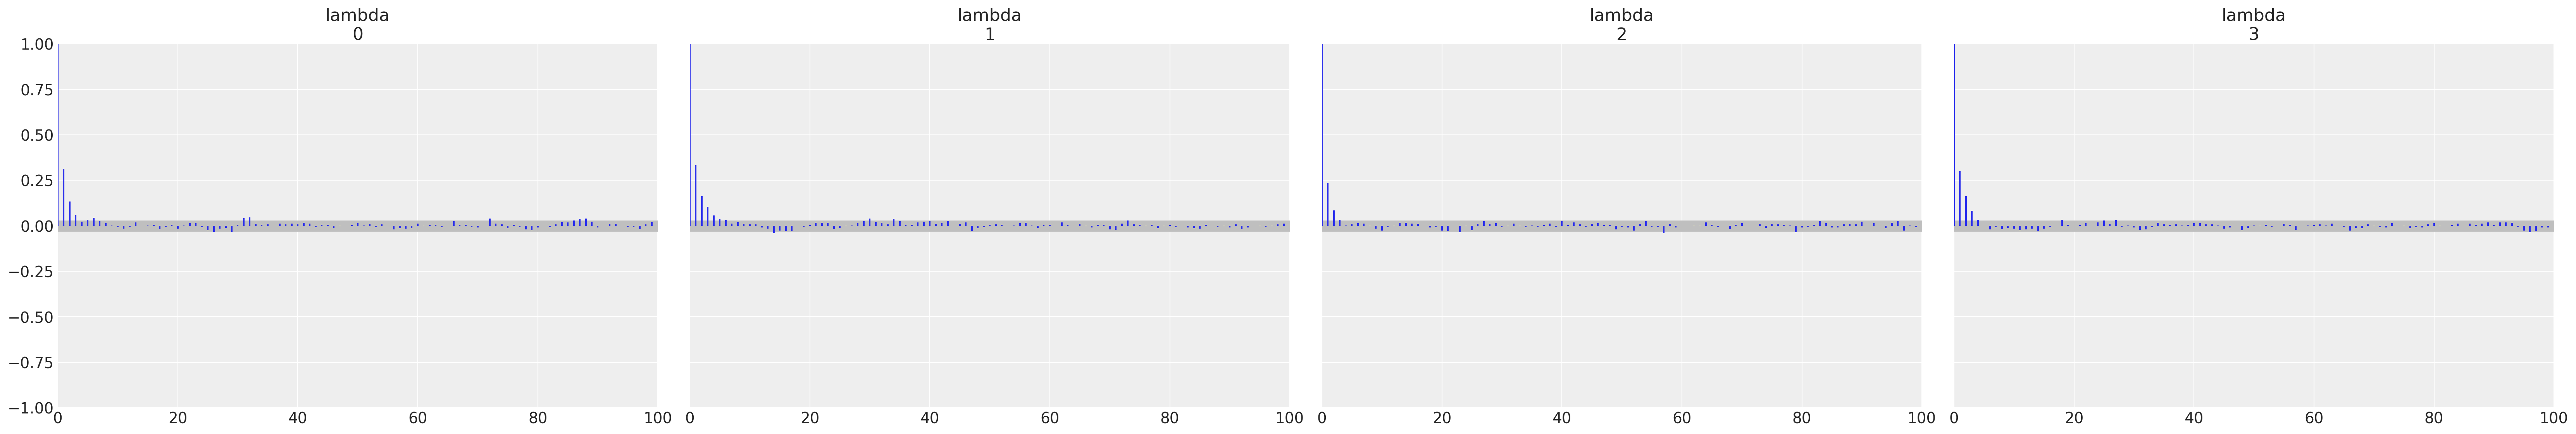

<IPython.core.display.Javascript object>

In [31]:
az.plot_autocorr(trace)

In [32]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda,4.311,1.212,2.199,6.632,0.013,0.009,8914.0,12934.0,1.0


<IPython.core.display.Javascript object>

In [33]:
watermark

Last updated: 2022-06-24T15:39:23.820515+02:00

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.1.1

Compiler    : Clang 12.0.1 
OS          : Darwin
Release     : 18.7.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



<IPython.core.display.Javascript object>